<strong>Aluno</strong>: Victor São Paulo Ruela



In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MLP para aproximação de funções

Neste trabalho é feita a implementação do algoritmo MLP com treinamento via back-propagation, e sua avaliação para a aproximação da função seno com ruído de medição uniforme.


In [55]:
Ntrain = 45
X = np.linspace(0, 2 * np.pi, Ntrain).reshape(-1,1)
y = np.sin(X) + np.random.uniform(-0.1,0.1, (len(X),1))

X_test = np.arange(0, 2 * np.pi, step=0.01).reshape(-1,1)
y_test = np.sin(X_test)

A seguir é feita a implementação do algoritmo MLP, usando como base as notas de aula. 

In [56]:
class MLP:
    def __init__(self, p, m, max_epochs=100, eta=0.01, tol=0.0001):
      self.p = p
      self.m = m
      self.eta = eta
      self.max_epochs = max_epochs
      self.tol = tol

    def sech2(self, u):
        return ((2/(np.exp(u)+np.exp(-u)))*(2/(np.exp(u)+np.exp(-u))))

    def fit(self, X, y):
        # augment X
        N, n = X.shape
        x_aug = np.hstack((np.ones((N, 1)), X))

        # initialize the weight and hidden layer matrixes
        w = np.random.uniform(-0.5, 0.5, (self.p+1, self.m))
        Z = np.random.uniform(-0.5, 0.5, (n+1, self.p))

        # initialize the main loop
        epochs = 0
        error_epoch = []
        ediff = np.Inf

        while((epochs < self.max_epochs) & (ediff > self.tol)):
            xseq = np.arange(N)
            np.random.shuffle(xseq)
            ei2 = 0
            for iseq in xseq:  
                # current input/output pair
                xa = x_aug[iseq,:]
                ya = y[iseq]
                
                # hidden layer pass
                U = xa.T @ Z
                H = np.tanh(U)
                H_aug = np.hstack((1, H)) #np.hstack((np.ones((N, 1)), H))
                
                # output layer pass
                O = H_aug @ w
                y_hat = O # apply linear activation function
                
                # propagate output error
                e = ya - y_hat
                dO = e * self.sech2(O) 
                # propagate hidden layer error
                # the bias should not be considered
                ehidden = dO @ w[:-1,:].T
                dU = ehidden * self.sech2(U)

                # update w and Z
                w = w + self.eta * (H_aug.reshape(1,-1).T @ dO.reshape(1,-1))
                Z = Z + self.eta * (xa.reshape(-1,1) @ dU.reshape(1,-1))

                ei2 = ei2 + (e @ e.T)
            
            ei2 = ei2 / N
            error_epoch.append(ei2)
            epochs = epochs + 1

            if(epochs > 1):
                ediff = np.abs(ediff - ei2)
            else:
                ediff = ei2
            
        self.coef_ = w
        self.Z_ = Z

        return self

    def predict(self, X):
        N, _ = X.shape
        x_aug = np.hstack((np.ones((N, 1)), X))
        # forward pass through hidden layer
        H = np.tanh(x_aug @ self.Z_)
        # add bias and forward pass on output layer
        H_aug = np.hstack((np.ones((N, 1)), H))
        yhat = H_aug @ self.coef_
        return yhat

 Para se obter uma função de ativação linear na camada de saída, foi considerado somente um neurônio, de forma que o saída final da rede é a soma das saídas de cada neurônio da camada escondida ponderado pelo respectivo peso. 
 
O algoritmo de treinamento é então executado 5 vezes. As aproximações obtidas e o MSE médio e desvio padrão são exibidos na figura a seguir.

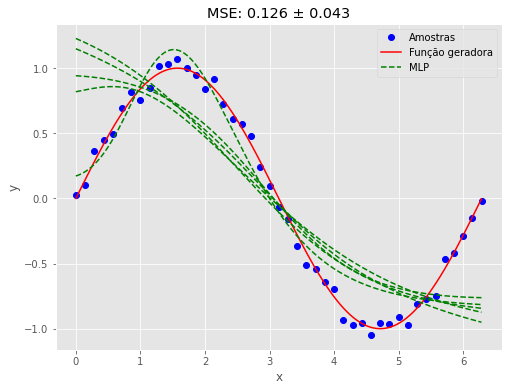

In [57]:
mse_array = []
max_epochs = 1000
n_hidden = 3
n_output = 1
learning_rate = 0.01
tol = 1e-5

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(X, y, 'bo', label='Amostras')
ax.plot(X_test, y_test, 'r-', label='Função geradora')

mlp = MLP(n_hidden, n_output, max_epochs, learning_rate, tol)
for i in range(5):
    mlp = mlp.fit(X,y)
    y_hat = mlp.predict(X_test)
    mse_array.append(mean_squared_error(y_test, y_hat))
    if(i == 0):
        ax.plot(X_test, y_hat, 'g--', label='MLP')
    else:
        ax.plot(X_test, y_hat, 'g--')

ax.set_title(f'MSE: {np.mean(mse_array):.3f} ± {np.std(mse_array):.3f}')
ax.legend()
fig.show()

A partir dos resultados acima, podemos observar que o algoritmo back-propagation é bastante sensível à inicialização aplicada. Vale a pena ressaltar que foi necessário um ajuste fino da quantidade máxima de épocas de treinamento e taxa de aprendizado. Observou-se também que o aumento exagerado do número épocas de treinamento levava o algoritmo a não convergir dependendo da escolha de ponto inicial. Estas observações comprovam a característica não-convexa deste modelo de rede neural, uma vez que o back-propagation é uma abordagem baseada em gradientes. Isso sugere o uso de técnicas de otimização mais robustas para lidar com esse problema.

Além disso, observa-se um pouco de underfitting para as aproximações obtidas, conforme visto pelos gráficos, embora as aproximações obtidades estão próximas do desejado. Destaca-se o fato do modelo ter conseguido aproximar melhor o primeiro pico, apresentando um maior erro de aproximação no ponto de mínimo da senóide em estudo. Isso sugere que um número maior de neurônios na camada escondida possa ser indicado para a melhora da aproximação obtida.